# Traitement des images en couleurs avec le dataset CIFAR 10.
- ce sont des images 32 x 32 de 10 objets différents: Avion, voiture, oiseau, chat, cerf, chien,grenouille,cheval,bateau,camion. Toutes en couleur

In [1]:
# import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import du jeu de données à partir de keras
from tensorflow.keras.datasets import cifar10

2022-04-21 16:09:57.181063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 16:09:57.181087: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# chargement du jeu de données en utlisant la méthode .load() et attribution en nos variables de tests et d'entraînement sous forme de tuples
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170508288/170498071 [==============================] - 8s 0us/step


In [4]:
# regardons la forme de nos données
# on a 50.000 images,32 pixels par 32 et 3 canaux de couleurs (Rouge,Vert et Bleu)
x_train.shape

(50000, 32, 32, 3)

In [5]:
# regardons 1 seul image
x_train[0].shape

(32, 32, 3)

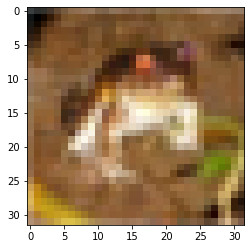

In [6]:
# tracage de l'image
plt.imshow(x_train[0])
# même si l'image est très pixélisée (très petite) on arrive distinguer avec un peu d'imagiantion que c'est une grenouille
# Pcq les images sont très petites, certaines images peuvent être mal classifiées au final, peu chance qu'on obtienne de si bonne performance

#  Pré-traitement des données

In [7]:
# voyons la valeur max de la première image 
# ca va de 0 à 255 pour chacune des 3 couleurs 
x_train[0].max()

255

In [8]:
# Normalisation des données d'entraînement à faire normalement avec la méthode MinMaxScaler mais ici on divise par la valeur max du x_train et x_test
# données d'entraînement sont les données d'images 
x_train=x_train/255
x_test=x_test/255

In [9]:
from tensorflow.keras.utils import to_categorical
y_cat_train= to_categorical(y_train,10)
y_cat_test=to_categorical(y_test,10)

In [10]:
y_train[0]

array([6], dtype=uint8)

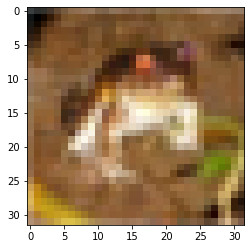

In [11]:
# Grenouille
plt.imshow(x_train[0])

# Création du modèle 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten
# seule chose à éditer ce sont les tailles, formes des données d'entrées(Input)
# input_shape est définit par nos données

In [13]:
# le nombre total de valeur pour CFAR10 sera de 3072 point de données 
# comme nos images sont plus grandes et plus complexes, rajout d'une couche supplémentaire de conv associée 
# a une seconde couche de pooling aussi
# les chercheurs aimes avoir différent nombres de filtres dans les différentes couhces convolutives 
# on peut avoir un nombre plus imortant  de filtres à mesures les couches convilutives vont plus en profondeur
32*32*3

3072

In [14]:
# construction du modèle 

model=Sequential()

## Premier set de couches

# Couche convolutive
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu'))
# Couche de Pooling
model.add(MaxPool2D(pool_size=(2, 2)))

## Second set de couches

# Couche convolutive
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(32, 32, 3), activation='relu'))
# Couche de Pooling
model.add(MaxPool2D(pool_size=(2, 2)))

# Images applaties de 32 par 32 à 3072 avant la couche finale
model.add(Flatten())

# 256 neurones dans la couche cachée dense 
model.add(Dense(256, activation='relu'))

# La dernière couche est le classificateur, donc 10 classes possibles
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

2022-04-21 16:17:44.321918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 16:17:44.321962: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 16:17:44.321991: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hprisser): /proc/driver/nvidia/version does not exist
2022-04-21 16:17:44.322344: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

In [16]:
# mise en place d'un callbacks
from tensorflow.keras.callbacks import EarlyStopping
early_stopped=EarlyStopping(monitor='val_loss',patience=3)

In [17]:
# entraînement du modèle 
# l'accuracy sur la première epochs n'est pas si bonne que ca et commence très bas
# Au faur et à mesure de l'entraînement, cette metrics augmente 
# l'accuracy par défaut serait de 10%, effet 10 types d'image,donc 1 chance sur 10 de la deviner correctement 
# le fait qu'on soit à une valeur 10 % pour notre excatitude est plutôt bon. on a 10 % de chance d'obtenir la bonne réponse 
model.fit(x_train,y_cat_train,epochs=15,validation_data=(x_test,y_cat_test),callbacks=[early_stopped])

2022-04-21 16:19:25.152266: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/15
1562/1563 [============================>.] - ETA: 0s - loss: 1.5125 - accuracy: 0.4515

2022-04-21 16:20:08.464261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


1563/1563 [==============================] - 31s 19ms/step - loss: 1.5123 - accuracy: 0.4516 - val_loss: 1.2692 - val_accuracy: 0.5480
Epoch 2/15
1563/1563 [==============================] - 29s 18ms/step - loss: 1.1901 - accuracy: 0.5804 - val_loss: 1.1753 - val_accuracy: 0.5804
Epoch 3/15
1563/1563 [==============================] - 29s 18ms/step - loss: 1.0422 - accuracy: 0.6344 - val_loss: 1.0312 - val_accuracy: 0.6404
Epoch 4/15
1563/1563 [==============================] - 29s 18ms/step - loss: 0.9297 - accuracy: 0.6760 - val_loss: 1.0296 - val_accuracy: 0.6410
Epoch 5/15
1563/1563 [==============================] - 29s 19ms/step - loss: 0.8396 - accuracy: 0.7082 - val_loss: 0.9895 - val_accuracy: 0.6556
Epoch 6/15
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7682 - accuracy: 0.7324 - val_loss: 0.9756 - val_accuracy: 0.6680
Epoch 7/15
1563/1563 [==============================] - 29s 19ms/step - loss: 0.7024 - accuracy: 0.7538 - val_loss: 1.0343 - val_accura

 # Evaluation du modèle

In [18]:
# lecture des metrics
metrics=pd.DataFrame(model.history.history)

<AxesSubplot:>

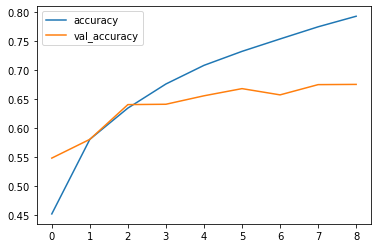

In [19]:
metrics[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

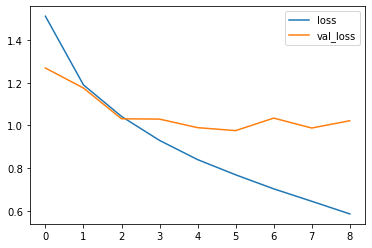

In [20]:
metrics[['loss','val_loss']].plot()

In [21]:
# pour voir l'évaluation finale
model.evaluate(x_test,y_cat_test,verbose=0)

2022-04-21 16:27:00.332514: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


[1.0220311880111694, 0.6753000020980835]

In [22]:
# rapport de classification et matrice de confusion
from sklearn.metrics import classification_report,confusion_matrix

In [23]:
# comme il s'agit d'une classification multi-classes, utilisation de np.argmax
# ceci afin de récupérer l'index de la colonne correspondant à la proba la plus forte
# Ce qui retourne pour chaque image test la classe ou la catégorie de l'image prédite
predictions=np.argmax(model.predict(x_test),axis=1)

2022-04-21 16:28:00.245878: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


In [24]:
print(classification_report(y_test,predictions))
# comparer l'accuracy globale de 0.68 à la prédiction aléatoire
# comme on a 10 classes, la prediction aléatoire donne 10% chances d'avoir la classe correcte 
# la classe qui performe moins bien c'est la classe 3: il semble que le modèle a du mal à reconnaître les chats

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      1000
           1       0.71      0.88      0.79      1000
           2       0.68      0.46      0.55      1000
           3       0.52      0.51      0.52      1000
           4       0.57      0.69      0.62      1000
           5       0.62      0.50      0.55      1000
           6       0.73      0.80      0.76      1000
           7       0.70      0.74      0.72      1000
           8       0.80      0.74      0.77      1000
           9       0.65      0.78      0.71      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.68      0.68      0.67     10000



In [25]:
# matrice de confusion pour voir combien d'image sont classifiées et combien sont mal classifiées
cm=confusion_matrix(y_test,predictions)
print(cm)

[[647  56  38  21  30   3  18  16  82  89]
 [  2 884   1   3   5   4   8   5   8  80]
 [ 57  20 460  71 150  56  90  40  28  28]
 [ 14  20  48 511  99 129  76  48  17  38]
 [ 12   9  35  52 692  28  51  90  12  19]
 [  5  14  34 210  86 499  26  84  10  32]
 [  3  15  26  50  60  25 799   8   2  12]
 [  6  12  19  40  83  46  16 737   3  38]
 [ 45  78   8  14  13   5   7   6 742  82]
 [ 14 135   8  10   6   6   7  14  18 782]]


<AxesSubplot:>

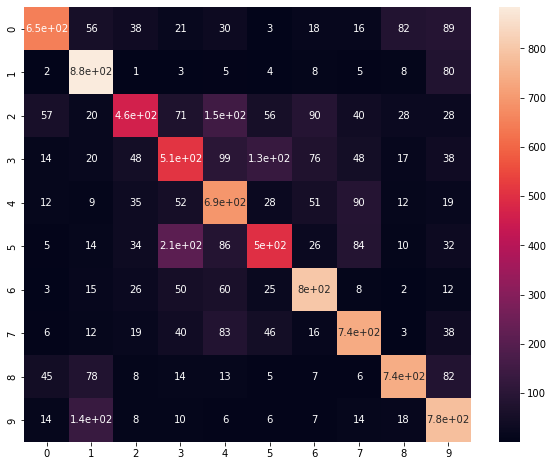

In [26]:
# en fonction de la couleur on peur voir ce qui est mal classifié
# il semble y avoir quelques confusions entre les classes 2 et 3 jusquà 5
#voir le nombre d'image mal classifié par classe
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True)

In [27]:
# voyons la permformance sur une seul image
my_image=x_test[9]

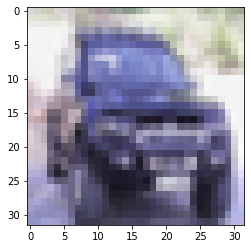

In [28]:
plt.imshow(my_image)

In [29]:
y_test[9]

array([1], dtype=uint8)

In [30]:
# pour récupérer les index de proba et donc avoir nos prédictions
# pas oublier de remodeler(reshape) l'image: pour avoir une image de 32 par 32 pixel de 3couleurs
np.argmax(model.predict(my_image.reshape(1,32,32,3)),axis=1)

array([1])